In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, optimizers, metrics
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Layer, Dense, BatchNormalization, Activation, Lambda

import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns 

In [2]:
print(keras.__version__)
tf.__version__

2.10.0


'2.10.0'

In [3]:
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/'+ '/'.join(folders) + '/' + fname)

file_cptac_vae_input = get_local_data_path(['processed_data'], 'CPTAC_TCGA_transcriptomics_VAE_input.parquet')

# Combined Transcriptomics (TCGA-Xena processed + CPTAC) 

In [4]:
combined_transcriptomics = pd.read_parquet(file_cptac_vae_input).drop(columns=['Study', 'Project'])
print(combined_transcriptomics.shape)
combined_transcriptomics[:2]

(12915, 12581)


,ABCC9,AGR3,TFF1,ABCC11,ABCC8,LMX1B,ABCA12,TMPRSS4,CEACAM5,PRAME,...,UBE2D3,CNOT2,PPWD1,DDX24,IWS1,PDCL,CWC22,ZNF143,ZNF317,APOH
X05BR044,-0.1642,-6.9695,7.315253,5.6987,-0.1320,9.006253,4.4880,3.713072,7.641153,4.239446,...,12.275687,10.487446,8.585484,11.455538,10.169584,8.862867,9.241903,8.464633,9.525920,0.0
X06BR006,3.5734,-2.2886,5.863440,3.0420,-0.3577,7.406507,3.2958,5.309702,7.748331,3.532511,...,12.284750,10.495988,8.608105,11.460543,10.111001,8.915071,9.168362,8.481458,9.539754,0.0


In [5]:
# # Determine most variably expressed genes and subset
transcriptomics_mad = pd.DataFrame(stats.median_abs_deviation(combined_transcriptomics, axis=0), 
                                   index = combined_transcriptomics.columns, 
                                   columns= ['MAD']).dropna().sort_values(by='MAD', ascending=False)
top_mad_genes = transcriptomics_mad.head(5000).index
vae_input = combined_transcriptomics.reindex(top_mad_genes, axis=1)
vae_input[:2]

,CEACAM6,TMPRSS4,CEACAM5,SERPINB5,SLC34A2,AGR2,PIGR,FOXA1,CXCL17,ALDH3B2,...,LDHB,ELL2,SLC1A4,RAB30,CTAGE6,ENO3,CNKSR1,HERC5,C5orf34,TSGA10
X05BR044,9.937472,3.713072,7.641153,7.282764,6.852082,0.4655,7.178882,12.949037,7.031997,5.5568,...,10.506106,10.041295,11.065826,6.242672,2.767518,4.983087,9.127218,5.523864,4.951109,5.306114
X06BR006,9.800047,5.309702,7.748331,6.626856,7.844841,-0.7228,8.373406,10.811038,7.350328,1.9811,...,11.874182,9.900537,10.134999,7.223504,2.353391,5.447281,8.347204,7.525570,5.377367,6.409235


In [6]:
# rnaseq_scaled_zeroone_df = transcriptomics_input
rnaseq_scaled_zeroone_df = MinMaxScaler().fit_transform(vae_input)
rnaseq_scaled_zeroone_df = pd.DataFrame(rnaseq_scaled_zeroone_df,
                                        columns=vae_input.columns,
                                        index=vae_input.index)
rnaseq_scaled_zeroone_df[:2]

,CEACAM6,TMPRSS4,CEACAM5,SERPINB5,SLC34A2,AGR2,PIGR,FOXA1,CXCL17,ALDH3B2,...,LDHB,ELL2,SLC1A4,RAB30,CTAGE6,ENO3,CNKSR1,HERC5,C5orf34,TSGA10
X05BR044,0.556158,0.268880,0.426972,0.471907,0.427291,0.340349,0.418665,0.870931,0.599509,0.523747,...,0.389687,0.599384,0.547150,0.539518,0.552344,0.296882,0.762243,0.398071,0.497599,0.529024
X06BR006,0.548890,0.370768,0.432470,0.430804,0.478019,0.305251,0.476576,0.738325,0.613836,0.402149,...,0.505430,0.586446,0.457733,0.616628,0.512752,0.322771,0.697101,0.545798,0.540439,0.639007


In [7]:
# Split 10% test set randomly
test_set_percent = 0.1
rnaseq_test_df = rnaseq_scaled_zeroone_df.sample(frac=test_set_percent)
rnaseq_train_df = rnaseq_scaled_zeroone_df.drop(rnaseq_test_df.index)

In [8]:
rnaseq_test_df[:2]

,CEACAM6,TMPRSS4,CEACAM5,SERPINB5,SLC34A2,AGR2,PIGR,FOXA1,CXCL17,ALDH3B2,...,LDHB,ELL2,SLC1A4,RAB30,CTAGE6,ENO3,CNKSR1,HERC5,C5orf34,TSGA10
TCGA-TM-A84J-01,0.057053,0.031931,0.034935,0.015532,0.245273,0.326600,0.113292,0.460395,0.283005,0.334777,...,0.637056,0.535846,0.423631,0.628931,0.287763,0.402119,0.471849,0.273801,0.642211,0.405783
TCGA-ET-A2MX-11,0.286047,0.418010,0.034935,0.015532,0.698518,0.493478,0.283459,0.180048,0.455389,0.361303,...,0.597293,0.612132,0.184438,0.485849,0.526769,0.397100,0.824275,0.584502,0.550754,0.747757


In [9]:
rnaseq_train_df[:2]

,CEACAM6,TMPRSS4,CEACAM5,SERPINB5,SLC34A2,AGR2,PIGR,FOXA1,CXCL17,ALDH3B2,...,LDHB,ELL2,SLC1A4,RAB30,CTAGE6,ENO3,CNKSR1,HERC5,C5orf34,TSGA10
X06BR006,0.548890,0.370768,0.432470,0.430804,0.478019,0.305251,0.476576,0.738325,0.613836,0.402149,...,0.505430,0.586446,0.457733,0.616628,0.512752,0.322771,0.697101,0.545798,0.540439,0.639007
X06BR005,0.382051,0.431915,0.291048,0.461353,0.440939,0.330735,0.467459,0.788839,0.502438,0.301906,...,0.436884,0.582706,0.563414,0.640206,0.583985,0.326446,0.764101,0.550662,0.538389,0.600252


### Define Autoencoder

In [10]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)
            

In [11]:
np.random.seed(123)

In [12]:
# Set hyper parameters
original_dim = rnaseq_scaled_zeroone_df.shape[1]
latent_dim = 500

batch_size = 50
epochs = 50
learning_rate = 0.0005

epsilon_std = 1.0
beta = K.variable(0)
kappa = 1

### Encoder

In [13]:
# Input place holder for RNAseq data with specific input size
rnaseq_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

Instructions for updating:
Colocations handled automatically by placer.


### Decoder

In [14]:
# The decoding layer is much simpler with a single layer and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
rnaseq_reconstruct = decoder_to_reconstruct(z)

### Connect the encoder and decoder to make the VAE

The CustomVariationalLayer() includes the VAE loss function (reconstruction + (beta * KL)), which is what will drive our model to learn an interpretable representation of gene expression space.

The VAE is compiled with an Adam optimizer and built-in custom loss function. The loss_weights parameter ensures beta is updated at each epoch end callback

In [15]:
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=None, loss_weights=[beta],
            experimental_run_tf_function=False)

vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5000)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 500)          2500500     ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 500)          2500500     ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 500)         2000        ['dense[0][0]']                  
 alization)                                                                                   

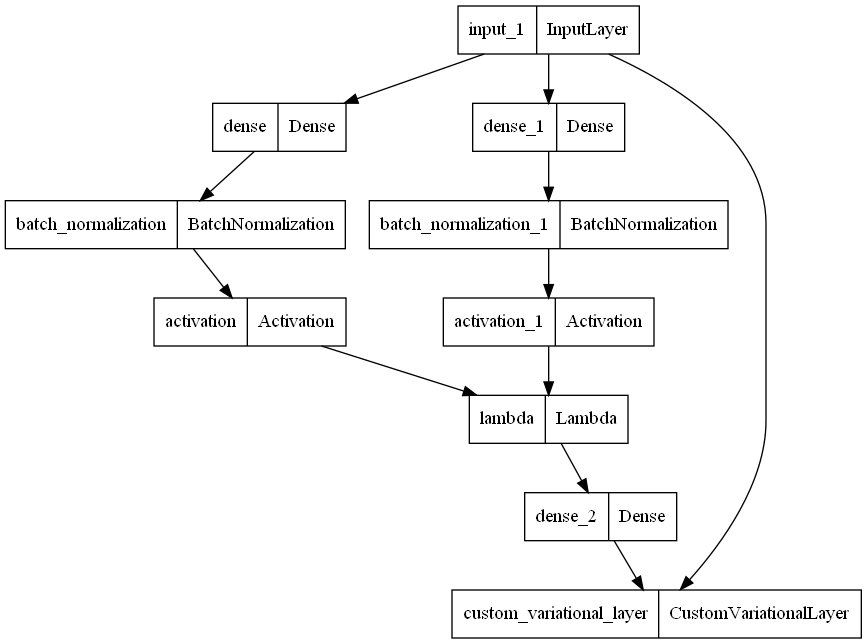

In [16]:
# Visualize the connections of the custom VAE model
output_model_file = get_local_data_path(['figures'], 'onehidden_vae500_architecture_cptac_trial.png')
plot_model(vae, to_file=output_model_file)

# SVG(model_to_dot(vae).create(prog='dot', format='svg'))

### Train the model

The training data is shuffled after every epoch and 10% of the data is heldout for calculating validation loss.

In [17]:
%%time
hist = vae.fit(np.array(rnaseq_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=0,
               batch_size=batch_size,
               validation_data=(np.array(rnaseq_test_df), None),
               callbacks=[WarmUpCallback(beta, kappa)])

CPU times: total: 18min 46s
Wall time: 9min 2s


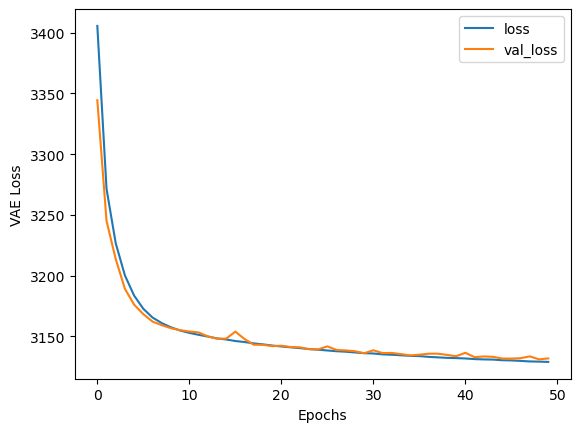

In [18]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = get_local_data_path(['figures'], 'onehidden_vae500_training_cptac_trial.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

### Compile and output trained models

We are interested in:

- The model to encode/compress the input gene expression data
    - Can be possibly used to compress other tumors
- The model to decode/decompress the latent space back into gene expression space
    - This is our generative model
- The latent space compression of all pan cancer TCGA samples
    - Non-linear reduced dimension representation of tumors can be used as features for various tasks
    - Supervised learning tasks predicting specific gene inactivation events
    - Interpolating across this space to observe how gene expression changes between two cancer states
- The weights used to compress each latent node
    - Potentially indicate learned biology differentially activating tumors

### Encoder model

In [19]:
# Model to compress input
encoder = Model(rnaseq_input, z_mean_encoded)

In [20]:
# Encode rnaseq into the hidden/latent representation - and save output
encoded_rnaseq_df = encoder.predict_on_batch(rnaseq_scaled_zeroone_df)
encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=rnaseq_scaled_zeroone_df.index)

encoded_rnaseq_df.columns.name = 'sample_id'
encoded_rnaseq_df.columns = encoded_rnaseq_df.columns + 1
encoded_rnaseq_df.rename(columns = lambda x: str(x), inplace=True)
encoded_file = get_local_data_path(['processed_data'], 'encoded_rnaseq_vae500_cptac_trial.parquet')
encoded_rnaseq_df.to_parquet(encoded_file)

### Decoder (generative) model

In [21]:
# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

### Save the encoder/decoder models for future investigation

In [22]:
encoder_model_file = get_local_data_path(['models'], 'encoder_onehidden_vae500_cptac_trial.hdf5')
decoder_model_file = get_local_data_path(['models'], 'decoder_onehidden_vae500_cptac_trial.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)

In [23]:
# What are the most and least activated nodes
sum_node_activity = encoded_rnaseq_df.sum(axis=0).sort_values(ascending=False)

# Top 10 most active nodes
print(sum_node_activity.head(10))

# Bottom 10 least active nodes
sum_node_activity.tail(10)

sample_id
285    28325.435547
193    28122.970703
357    25358.255859
212    23092.376953
479    21998.333984
120    21929.695312
304    21455.921875
440    21416.431641
272    20709.300781
67     20571.978516
dtype: float32


sample_id
425    5041.224121
459    4939.172363
429    4812.254395
154    4715.691895
10     4704.793457
499    4184.259766
362    4179.766602
382    4126.765137
293    4006.781494
324    2772.535645
dtype: float32

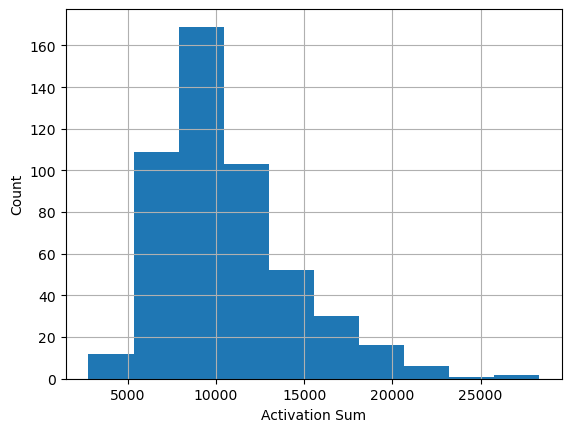

In [24]:
# Histogram of node activity for all 100 latent features
sum_node_activity.hist()
plt.xlabel('Activation Sum')
plt.ylabel('Count');

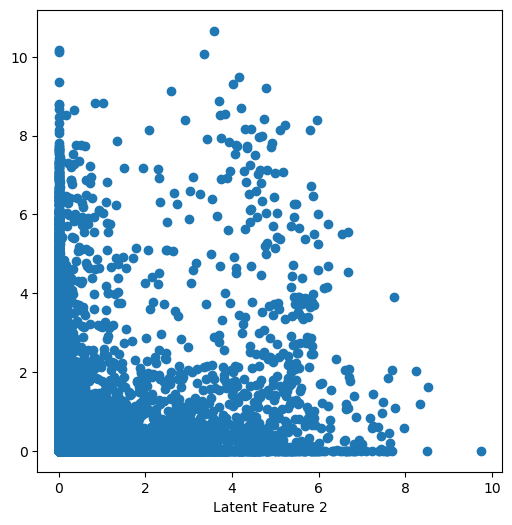

In [25]:
# Example of node activation distribution for the first two latent features
plt.figure(figsize=(6, 6))
plt.scatter(encoded_rnaseq_df.iloc[:, 1], encoded_rnaseq_df.iloc[:, 2])
plt.xlabel('Latent Feature 1')
plt.xlabel('Latent Feature 2');

#### Observe reconstruction fidelity

In [26]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct = decoder.predict(np.array(encoded_rnaseq_df))
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct, 
                                        index=rnaseq_scaled_zeroone_df.index,
                                        columns=rnaseq_scaled_zeroone_df.columns)
input_rnaseq_reconstruct.head(2)

,CEACAM6,TMPRSS4,CEACAM5,SERPINB5,SLC34A2,AGR2,PIGR,FOXA1,CXCL17,ALDH3B2,...,LDHB,ELL2,SLC1A4,RAB30,CTAGE6,ENO3,CNKSR1,HERC5,C5orf34,TSGA10
X05BR044,0.499449,0.303177,0.385508,0.404194,0.403139,0.348212,0.424862,0.799701,0.592482,0.424984,...,0.439145,0.595851,0.563001,0.618636,0.564865,0.314546,0.72776,0.505731,0.562209,0.584954
X06BR006,0.461112,0.291376,0.336228,0.432038,0.406780,0.364411,0.453666,0.763770,0.561799,0.396807,...,0.483289,0.589941,0.532056,0.646664,0.533723,0.291864,0.67001,0.548001,0.583150,0.563879


In [27]:
reconstruction_fidelity = rnaseq_scaled_zeroone_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_scaled_zeroone_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
RPS28,-0.009381,0.145027
RPL9,-0.007433,0.131305
SLC44A5,-0.026207,0.119041
ERAP2,0.005600,0.113706
NLRP2,0.007600,0.111792


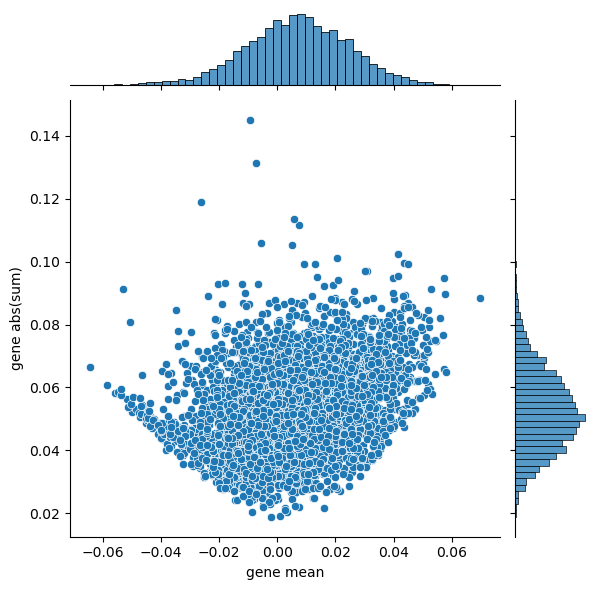

In [28]:
# Mean of gene reconstruction vs. absolute reconstructed difference per sample
g = sns.jointplot(x='gene mean', y='gene abs(sum)', data=gene_summary);